# DeepLabV2 - Classic Semantic Segmentation Network

## INTRODUCTION

Semantic segmentation is a fundamental task in computer vision that involves assigning a class label to each pixel in an image. In this project, we focus on training and evaluating a classic deep learning-based segmentation model, **DeepLabV2**, on the **Cityscapes** dataset. The goal is to assess the model’s performance in terms of segmentation quality and computational efficiency using metrics such as mean Intersection over Union (mIoU), latency, number of parameters, and FLOPs.

**Cityscapes** is a large-scale benchmark dataset specifically designed for urban scene understanding. It comprises 5,000 high-quality pixel-level annotated images, divided into 2,975 training, 500 validation, and 1,525 test images. Additionally, it includes 20,000 coarsely labeled images, often used for pretraining. The data was collected from 50 European cities, capturing a wide range of traffic and weather conditions. The images are high resolution (2048×1024), and evaluation is based on 19 semantic classes, grouped into 7 super-categories: ground, construction, object, nature, sky, human, and vehicle. The void class is excluded from the evaluation.

### Training details

* **Dataset** Cityscapes
* **Training epochs** 50
* **Input resolution** 1024×512 (for both training and testing)
* **Backbone** ResNet-101 (ImageNet pre-trained)
* **Semantic classes** 19
* **Metrics** mIoU (mean and per class), latency, FLOPs, number of parameters

## Loss Functions for Semantic Segmentation: A Comprehensive Comparison

In the realm of semantic segmentation, selecting the appropriate loss function is paramount for guiding model learning and achieving optimal performance, especially when confronting challenges like class imbalance and the need for precise object boundaries. Commonly employed loss functions include Cross-Entropy, Dice Loss, Lovász-Softmax Loss, Tversky Loss, and Focal Loss, each possessing unique characteristics that dictate its applicability.

The **Cross-Entropy Loss** ($CE$) is the standard loss for classification problems, extended pixel-wise to segmentation. For a single class and pixel, it's defined as $CE(p, y) = -y \log(p) - (1-y) \log(1-p)$, where $y$ is the ground truth (0 or 1) and $p$ is the predicted probability. Its strength lies in its simplicity and direct measurement of the divergence between predicted and true probability distributions. However, it tends to be sensitive to class imbalance, penalizing all pixels equally regardless of their frequency, which can lead to inferior performance on minority classes [goodfellow2016deep].

The **Dice Loss**, derived from the Dice coefficient, is particularly effective for problems with significant class imbalance and for improving boundary precision. Its formula is given by $Dice(P, G) = 1 - \frac{2|P \cap G|}{|P| + |G|}$, where $P$ and $G$ represent the predicted and ground truth pixel sets, respectively. A key advantage is its direct correlation with IoU (Intersection over Union), a common evaluation metric in segmentation, making it ideal for optimizing the overlap between predictions and ground truth. Yet, it can struggle with very small objects, where even a slight error can significantly impact the Dice coefficient, and may lead to smooth predictions that fail to capture fine details [milletari2016v].

The **Lovász-Softmax Loss** directly aims to optimize the non-differentiable Intersection over Union (mIoU) metric by approximating it with a convex surrogate. While its formula is more complex, involving the sorting of losses for pixels, its main strength is its ability to yield excellent results in terms of IoU, as demonstrated in various segmentation competitions. This loss is particularly useful when mIoU is the primary evaluation metric, though its implementation can be more involved than other losses [berman2018lovasz].

The **Tversky Loss** is a generalization of the Dice Loss, introducing two parameters $\alpha$ and $\beta$ to balance the importance of false positives (FP) and false negatives (FN). The formula is $Tversky(P, G) = \frac{|P \cap G|}{|P \cap G| + \alpha |P - G| + \beta |G - P|}$, where $|P - G|$ represents false positives and $|G - P|$ false negatives. It allows for greater flexibility in weighting different error types, which is advantageous in scenarios where one type of error is more critical than another (e.g., minimizing FNs in medical diagnostics). The trade-off is the need to tune these hyperparameters [salehi2017tversky].

Finally, the **Focal Loss** was introduced to address the problem of class imbalance and "hard examples" in object detection. Its formula is $FL(p_t) = - \alpha_t (1 - p_t)^\gamma \log(p_t)$, where $p_t$ is the ground truth probability, $\alpha_t$ is a balancing factor for classes, and $\gamma$ is the "focusing parameter" that reduces the weight of easy predictions. Its strengths lie in its effectiveness in focusing learning on challenging and rare examples, thereby improving performance on minority classes and complex boundaries. However, it requires tuning $\gamma$ and $\alpha_t$, and too high a $\gamma$ value might lead to ignoring easy but important examples [lin2017focal].

In summary, while Cross-Entropy serves as a solid starting point, the other loss functions offer more robust solutions for tackling the inherent challenges of semantic segmentation, such as class imbalance and the need for precise boundaries, each with its own strengths and weaknesses that guide its selection based on the specific problem and dataset.

In the following sections, we provide a detailed comparison of DeepLabV2 and other architectures, analyzing training dynamics, segmentation quality, and efficiency trade-offs.

## Model Description: Architectures and Training Strategies

The following section provides an overview of the DeepLabV2 model implemented and used for the experimental tests. The network was configured with the DeepLabV2 architecture, which uses a combination of ResNet-101 as the backbone and a classification module based on ASPP (Atrous Spatial Pyramid Pooling).

### Backbone: ResNet-101
The backbone uses the ResNet-101 variant, consisting of 4 main blocks:

- layer1: 3 bottleneck blocks
- layer2: 4 bottleneck blocks
- layer3: 23 bottleneck blocks (with expansion 2)
- layer4: 3 bottleneck blocks (with expansion 4)

Each bottleneck block combines three sequential convolutions (1x1 → 3x3 → 1x1) and a residual connection. Batch normalisations within these blocks are configured with requires_grad=False to freeze parameters, as is typical in ImageNet transfers.

### ASPP Module (ClassifierModule)
The ClassifierModule represents the ASPP: a set of 3x3 convolutions with different expansion rates (6, 12, 18, 24) and corresponding padding. The predictions of the different branches are summed up to obtain a robust final map in multiscale contexts.

### Optimisation Strategies
Common training configurations, in line with the literature and standard practices, include:

Optimiser: SGD (Stochastic Gradient Descent)
- Learning Rate Policy: poly policy
- Momentum: 0.9
- Weight Decay: 0.0005
- Loss: pixel-wise cross-entropy with ground truth downsampled to 1/8

As stated in the original documentation (paper 2), the use of optimisers other than SGD can adversely affect network training, which is why this configuration has been retained.

### Forward Pass and Optimisation Parameters
The ResNetMulti class defines the complete pipeline:
- Feature extraction via ResNet-101 layers.
- Pixel-wise classification via ASPP (layer6).
- Bilinear upsampling to restore the original resolution of the input image.

For the configuration of the optimiser, the following are provided:
- Backbone parameters (get_1x_lr_params_no_scale): base rate.
- ASPP parameters (get_10x_lr_params): 10x rate.

### Pre-training
The model can be initialised with pretrained weights on ImageNet, automatically loaded at start-up if pretrain=True (file: DeepLab_resnet_pretrained_imagenet.pth).

### Initial Configuration of Each Model

**Common Optimization and Training Parameters (Derived from Paper and Standard Practices):**

All models were trained using the following base optimization parameters, unless explicitly specified otherwise for a particular run:

* **Optimizer:** Stochastic Gradient Descent (SGD)
* **Learning Rate Policy:** `poly` policy, defined by $lr = \text{initial\_lr} \cdot (1 - \text{iter} / \text{max\_iter})^{\text{power}}$, with $\text{power} = 0.9$ as the default value (if not otherwise specified or modified during the run).
* **Momentum:** $0.9$
* **Weight Decay:** $0.0005$
* **Base Loss Function:** Sum of pixel-wise cross-entropies, applied with an $8 \times$ subsampled ground truth.

It is important to note that, as suggested in the original paper and confirmed by the notes, changing the optimizer from SGD is not recommended for DeepLabV2 + ResNet-101 due to its sensitivity to modifications in the learning rate update regime.


The table below summarizes the initial specific configurations for each of the 8 runs. The Learning Rate (LR) indicated is the initial value used for the `poly` policy.

| Run | CSV File Name | Initial Loss Function | Initial Combination | Initial LR | Initial Extra Strategies |
| :-- | :---------------------------------- | :-------------------- | :------------------ | :--------- | :------------------------------- |
| 1 | `DeeplabV2_ce` | Cross-Entropy (CE) | --- | 0.0001 | --- |
| 2 | `DeepLabV2_ce07_tv03` | CE + Lovász | 0.5 / 0.5 | 0.0001 | --- |
| 3 | `DeepLabV2_ce05_lv05` | CE + Tversky | 0.7 / 0.3 | 0.0001 | --- |
| 4 | `DeepLabV2_cv07_di03` | CE + Dice | 0.7 / 0.3 | 0.0001 | --- |
| 5 | `DeepLabV2_ce07_l03_warnup_lr_0.0002` | CE + Focal + Lovász | 0.6 / 0.2 / 0.2 | $0.0001$ | --- |
| 6 | `DeepLabV2_ce05_f05_warnup_lr_0.0003` | CE + Lovász | 0.7 / 0.3 $\gamma=2.0$| $0.0002$ | Warmup 500 steps |
| 7 | `DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002` | CE + Lovász + Dice | 0.5 / 0.25 / 0.25 | $0.0002$ | --- |
| 8 | `DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001` | CE + Focal | 0.6 / 0.2 / 0.2 $\gamma=2.0$ | $0.0003$ | Warmup 500 steps |


### Run Configuration Details

This section summarizes the main hyperparameter settings for each training run, along with the rationale behind their selection.

#### **Run 1: `DeeplabV2_ce.csv`**
- **Loss**: Cross-Entropy (CE)
- **Motivation**: Standard baseline for semantic segmentation; serves as a reference to evaluate more complex losses.
- **Learning Rate**: 0.001
- **Weight Decay**: 5e-4
- **Warm-up**: Disabled

#### **Run 2: `DeepLabV2_ce07_tv03.csv`**
- **Loss**: Combination of CE (0.7) + Tversky (0.3)
- **Motivation**: CE provides general performance, while Tversky compensates for class imbalance by focusing on under-represented classes.
- **Alpha (α)**: 0.7 CE, 0.3 Tversky
- **Gamma / β (Tversky)**: Default (usually β = 0.7)
- **Learning Rate**: 0.001
- **Warm-up**: Disabled

#### **Run 3: `DeepLabV2_ce05_lv05.csv`**
- **Loss**: CE (0.5) + Lovász (0.5)
- **Motivation**: Combining CE with Lovász aligns the training objective with the mIoU evaluation metric, improving segmentation quality.
- **Learning Rate**: 0.001
- **Warm-up**: Disabled

#### **Run 4: `DeepLabV2_cv07_di03.csv`**
- **Loss**: Combo Loss: 0.7 CE + 0.3 Dice
- **Motivation**: Dice loss helps better segment small or irregular classes, combined with CE for generalization.
- **Learning Rate**: 0.001
- **Warm-up**: Disabled

### **Run 5: `DeepLabV2_ce07_l03_warnup_lr_0.0002`**
- **Loss**: CE + Lovász
- **Weights**: 0.7 / 0.3 initially, then adjusted to 0.5 / 0.5
- **Learning Rate**: 0.0002
- **Warm-up**: Enabled
- **Additional Notes**:
    - Learning rate decay power adjusted dynamically (1.2 → 2.0 → 1.2)
    - Backbone layers 1–4 and `bn1` frozen from epoch 46 onward to refine deeper layers

* **After 28 epochs:** The $\text{power}$ parameter of the `poly` Learning Rate Policy was increased to $1.2$. This resulted in a slightly faster decay of the Learning Rate, with the aim of stabilizing the model and refining the segmentation more effectively, potentially leading to an immediate increase in mIoU.
* **From epoch 46 onwards:** More significant modifications were introduced:
    * The loss function weights were modified to $\alpha = 0.5$ and $\beta = 0.5$ to further stabilize the training process.
    * Layers 1, 2, 3, 4 and $\text{bn1}$ (Batch Normalization layer 1) of the backbone were **frozen**. This was done to concentrate learning on the deeper layers and refine details.
    * The $\text{power}$ parameter was increased to $2$, to accelerate the Learning Rate decay even further.
* **At epoch 47:** The $\text{power}$ parameter was reverted to $1.2$. This change was implemented to prevent an excessively rapid decay of the Learning Rate, which could have compromised the model's stability and learning capacity.


### **Run 6: `DeepLabV2_ce05_f05_warnup_lr_0.0003`**
- **Loss**: CE + Focal
- **Weights**: 0.5 / 0.5
- **Focal gamma**: 2.0
- **Learning Rate**: 0.0003
- **Warm-up**: Enabled (500 steps)
- **Additional Notes**:
    - Learning rate decay power set to 1.0 for faster convergence
    - Backbone layers 1–4 and `bn1` frozen at epoch 44

Run 6 also featured targeted modifications:

* The $\text{power}$ parameter of the `poly` policy was changed to $1.0$. This modification was applied to slightly accelerate the Learning Rate decay, with the intention of helping the model converge and "close better" in the final 20 epochs.
* **At epoch 44:** Layers 1, 2, 3, 4, and $\text{bn1}$ (Batch Normalization layer 1, likely "bin1" from the original text) of the backbone were **frozen**. This concentrated learning on subsequent layers.


### **Run 7: `DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002`**
- **Loss**: CE + Lovász + Dice
- **Weights**: 0.5 / 0.25 / 0.25
- **Learning Rate**: 0.0002
- **Warm-up**: Disabled
- **Additional Notes**:
    - Learning rate decay power increased to 1.1

In Run 7, the focus was on the Learning Rate decay:

* The $\text{power}$ parameter was changed from $0.9$ (default value) to $1.1$. This modification was implemented to allow the model to refine faster, reduce the Learning Rate slightly more rapidly in subsequent epochs, and help the model consolidate class details, an especially important aspect for the DeepLabV2 architecture.


### **Run 8: `DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001`**
- **Loss**: CE + Lovász + Focal
- **Weights**: 0.6 / 0.2 / 0.2
- **Focal gamma**: 2.0
- **Learning Rate**: 0.0001
- **Warm-up**: Disabled


---

### Design rationale
All models were trained using the **DeepLabV2** architecture with a ResNet-based backbone. Despite being a classical method, DeepLabV2 remains competitive for structured segmentation tasks like Cityscapes. Loss combinations were chosen to balance:
- **Baseline strength (CE)**
- **Imbalance robustness (Tversky, Focal, Dice)**
- **Metric alignment (Lovász)**

By comparing different configurations, the goal was to assess how each loss contributes to stability, performance, and per-class accuracy.

## Results

| Run | Method     | mIoU val (%) | Latency | FLOPs | Params  |
| :-- | :---------------------------------- |----------|---------|-------|---------|
| 1 | `DeeplabV2_ce` | 50.50 | 141.06 | 374.66  | 43795724 |
| 2 | `DeepLabV2_ce07_tv03` | 50.10 | 242.35 | 374.66 | 43795724 |
| 3 | `DeepLabV2_ce05_lv05` | 50.82 | 225.46 | 374.66 | 43795724 |
| 4 | `DeepLabV2_cv07_di03` | 50.17 | 248.61 | 374.66 | 43795724 |
| 5 | `DeepLabV2_ce07_l03_warnup_lr_0.0002` | 53.79 | 238.74 | 374.66 | 2835724 |
| 6 | `DeepLabV2_ce05_f05_warnup_lr_0.0003` | 53.9948 | 249.03 | 374.66 | 2835724 |
| 7 | `DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002` | 53.31 | 304.54 | 374.66 | 43795724 |
| 8 | `DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001` | 50.37 | 245.34 | 374.66 | 43795724 |


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast # To parse string representations of lists/arrays

## Learning rate dacay

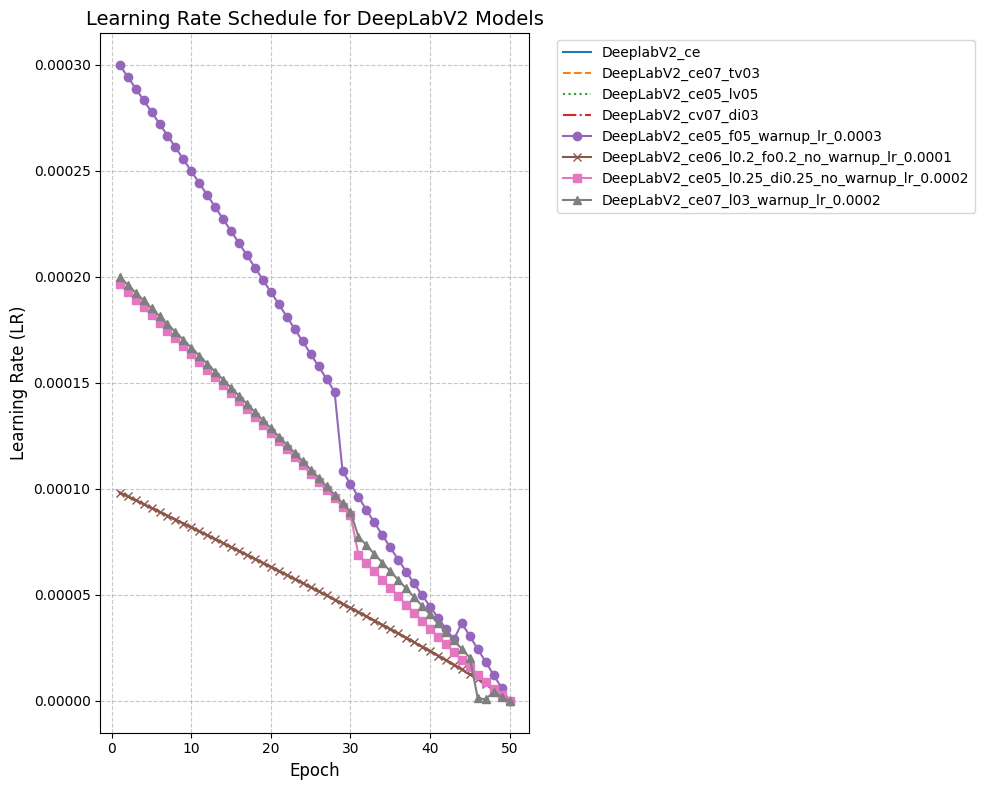

In [ ]:
# List of your CSV file names
file_names = [
    "DeeplabV2_ce.csv",
    "DeepLabV2_ce07_tv03.csv",
    "DeepLabV2_ce05_lv05.csv",
    "DeepLabV2_cv07_di03.csv",
    "DeepLabV2_ce05_f05_warnup_lr_0.0003.csv",
    "DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001.csv",
    "DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002.csv",
    "DeepLabV2_ce07_l03_warnup_lr_0.0002.csv"
]

# Define a list of different line styles and markers to cycle through
# Matplotlib automaticamente cicla i colori, quindi ci concentreremo su stili di linea e marcatori.
line_styles = ['-', '--', ':', '-.',  # Stili di linea standard
               'o-', 'x-', 's-', '^-'] # Stili di linea con marcatori (punto, croce, quadrato, triangolo)

plt.figure(figsize=(12, 8)) # Figura leggermente più grande per una migliore leggibilità

for i, file_name in enumerate(file_names):
    # Usa l'operatore modulo per ciclare attraverso la lista di stili
    current_style = line_styles[i % len(line_styles)]

    try:
        # Assicurati che i file CSV siano nella stessa directory dello script Python,
        # oppure specifica il percorso completo del file:
        # df = pd.read_csv(os.path.join("C:/Percorso/Alla/Tua/Cartella/", file_name))
        df = pd.read_csv(file_name)

        # Estrai le colonne 'epoch' e 'lr'
        if 'epoch' in df.columns and 'lr' in df.columns:
            epochs = df['epoch']
            lrs = df['lr']
            
            # Usa il nome del file (senza estensione) per la legenda
            label = os.path.splitext(file_name)[0]
            
            # Disegna la linea con lo stile/marcatore assegnato
            plt.plot(epochs, lrs, current_style, label=label, linewidth=1.5) # Aggiunto linewidth per chiarezza
        else:
            print(f"Saltando '{file_name}': Colonne 'epoch' o 'lr' mancanti.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione di '{file_name}': {e}")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate (LR)", fontsize=12)
plt.title("Learning Rate Schedule for DeepLabV2 Models", fontsize=14)
# Posiziona la legenda fuori dal grafico, adatta il layout per fare spazio
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7) # Migliorata la visibilità della griglia
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adatta il layout per fare spazio alla legenda sulla destra
plt.show()

## Train vs Validation loss
### **Train vs Validation Loss per loss function combination**

* **What it shows**: For each loss combination (CE, Tversky, Lovász, Focal, Combo), the loss trend on training and validation is displayed.
* **Interpretation**: Methods with **Tversky** and **Focal** show a more irregular curve, a sign of greater instability. The **Lovász Loss** converges more stably and produces a lower validation loss, suggesting a better generalisability.

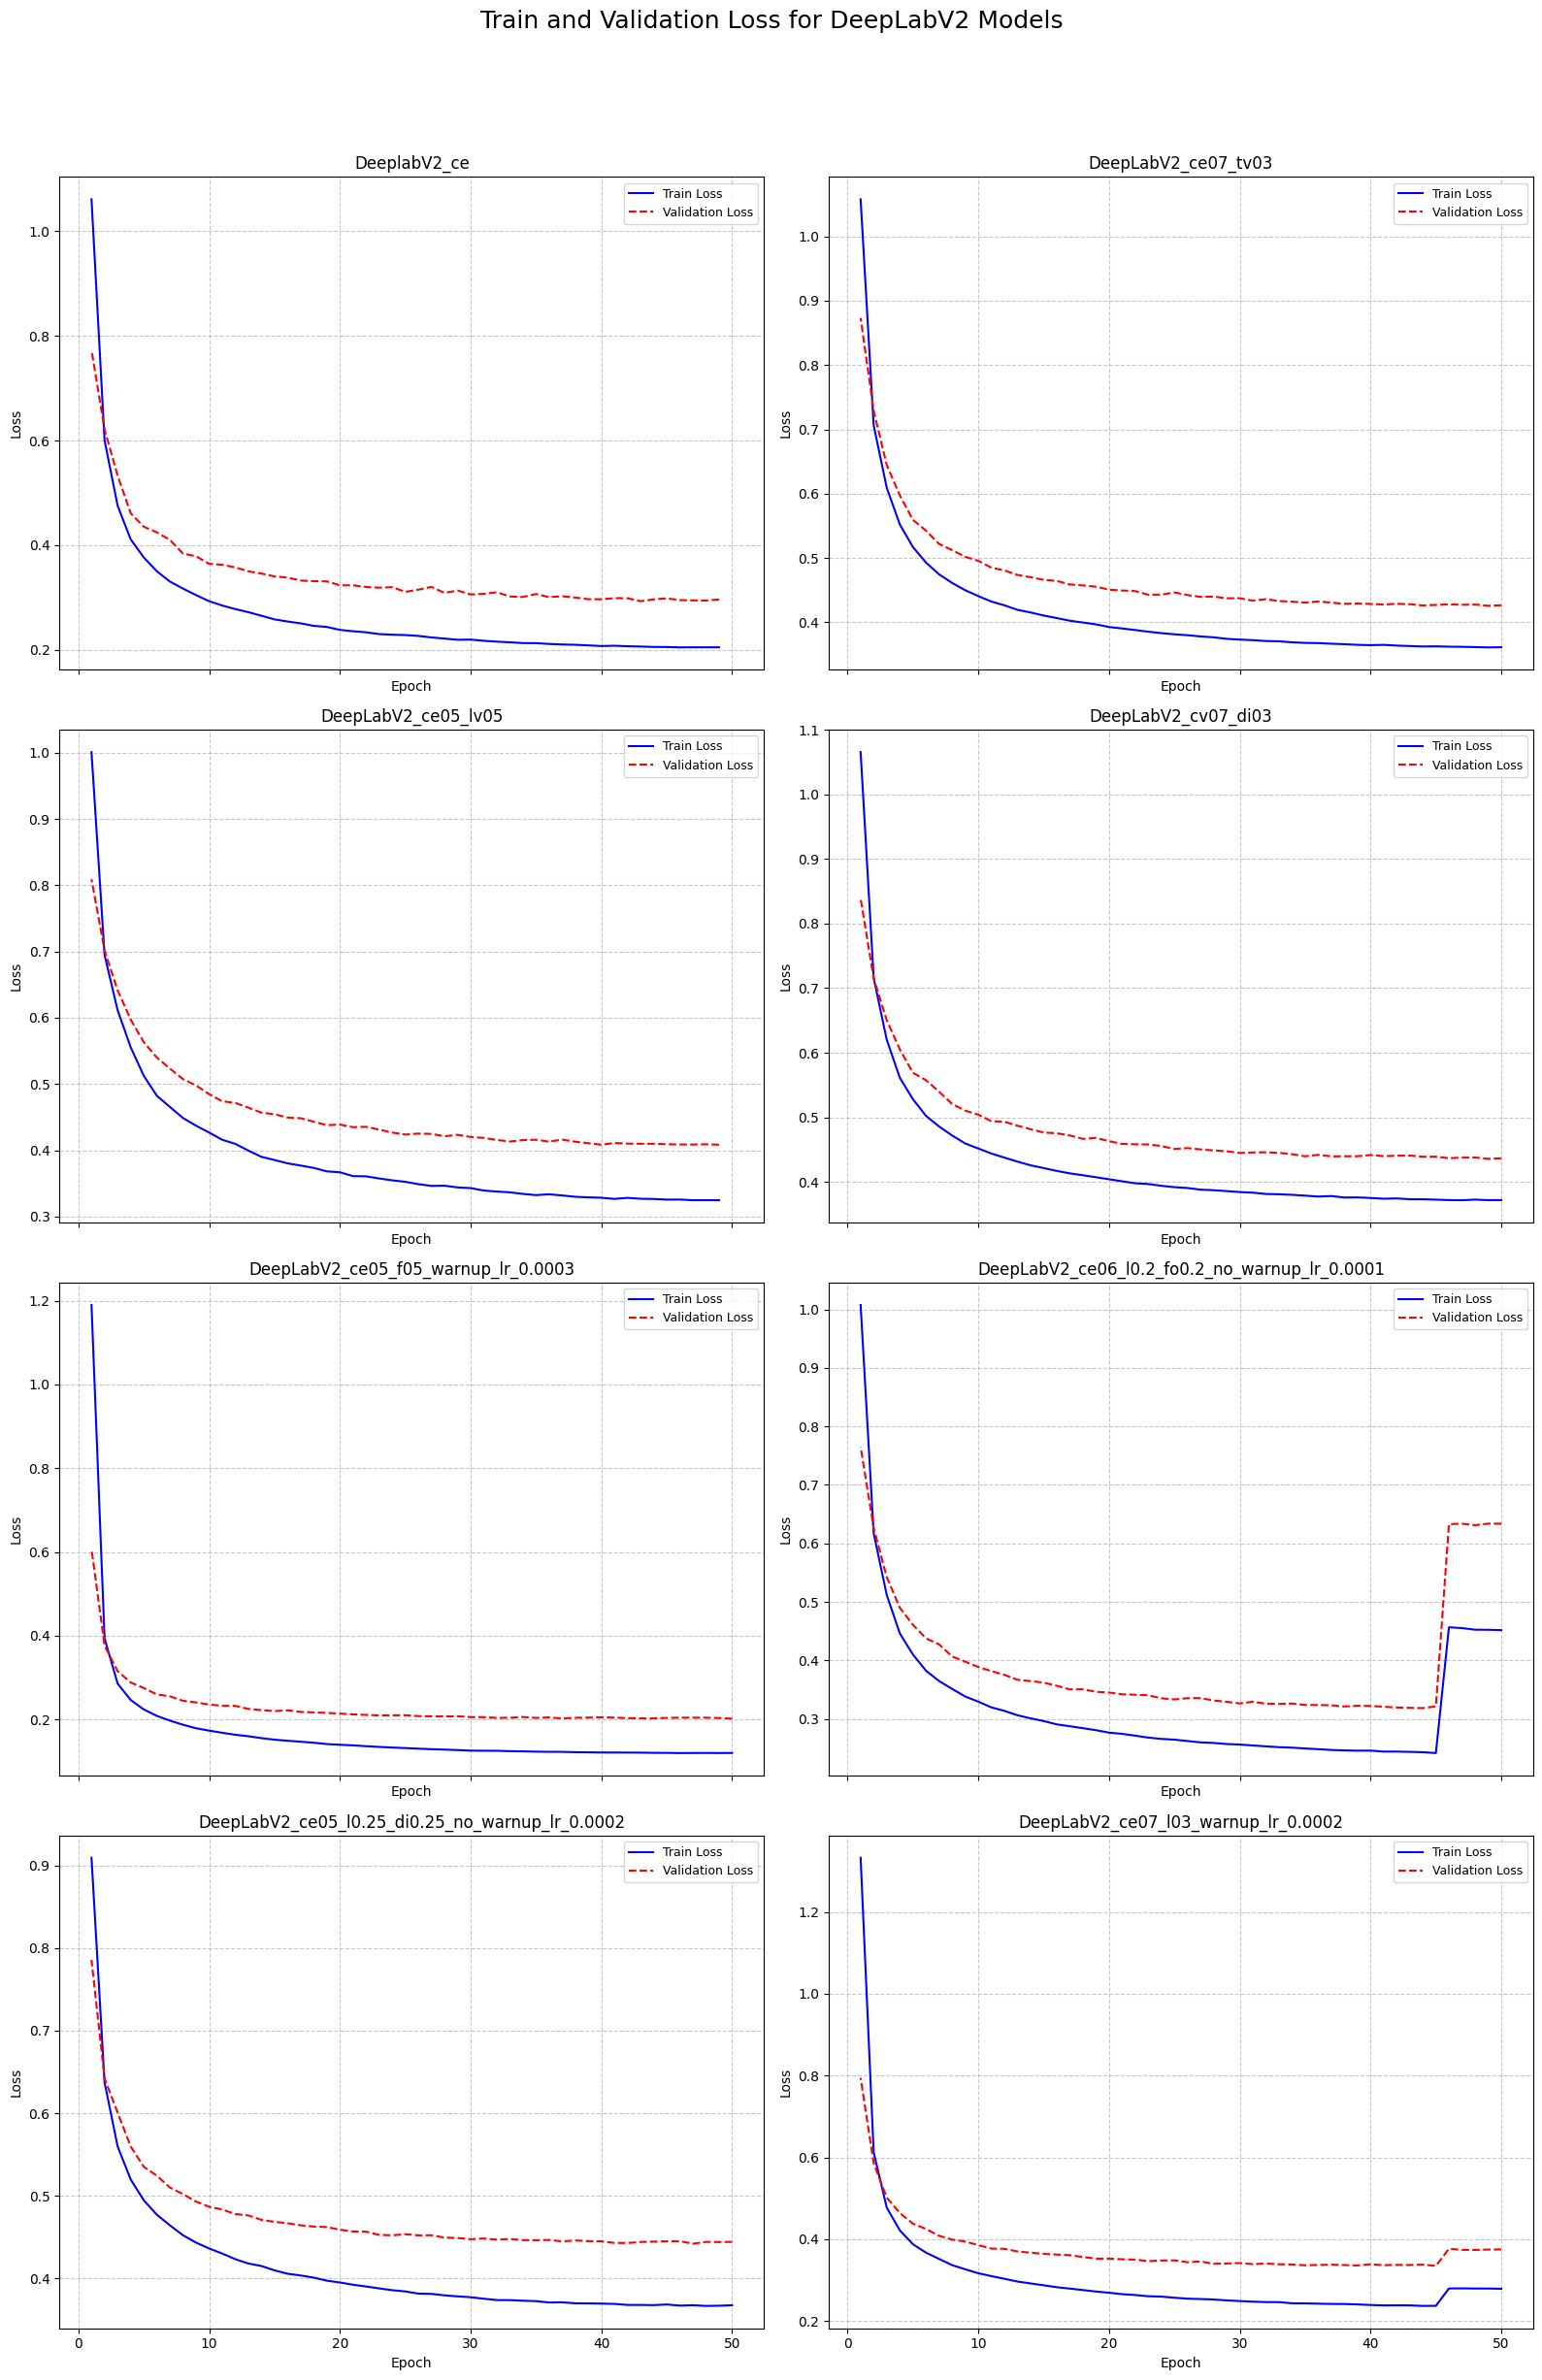

In [8]:
# Create a figure with a grid of subplots (e.g., 4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 24), sharex=True, sharey=False) # sharex=True per allineare gli assi x
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

fig.suptitle("Train and Validation Loss for DeepLabV2 Models", fontsize=18, y=1.02) # Main title for the figure

for i, file_name in enumerate(file_names):
    ax = axes[i] # Get the current subplot axis
    
    try:
        df = pd.read_csv(file_name)

        # Check for required columns
        required_cols = ['epoch', 'train_loss', 'val_loss']
        if all(col in df.columns for col in required_cols):
            epochs = df['epoch']
            train_loss = df['train_loss']
            val_loss = df['val_loss']
            
            # Use the base file name (without extension) for the subplot title
            model_name = os.path.splitext(file_name)[0]
            
            ax.plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=1.5)
            ax.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=1.5)
            
            ax.set_title(f"{model_name}", fontsize=12)
            ax.set_xlabel("Epoch", fontsize=10)
            ax.set_ylabel("Loss", fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            missing_cols = [col for col in required_cols if col not in df.columns]
            ax.set_title(f"Skipping {file_name}: Missing columns {missing_cols}", fontsize=10)
            ax.text(0.5, 0.5, "Data N/A", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            print(f"Skipping '{file_name}': Missing columns: {missing_cols}")
            
    except FileNotFoundError:
        ax.set_title(f"File Not Found: {file_name}", fontsize=10)
        ax.text(0.5, 0.5, "File Missing", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"Error: File '{file_name}' not found. Please ensure it's in the correct directory.")
    except Exception as e:
        ax.set_title(f"Error for {file_name}", fontsize=10)
        ax.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"An error occurred while processing '{file_name}': {e}")

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent main title overlap
plt.show()

## Train and Validation loss allover the DeepLabV2 models

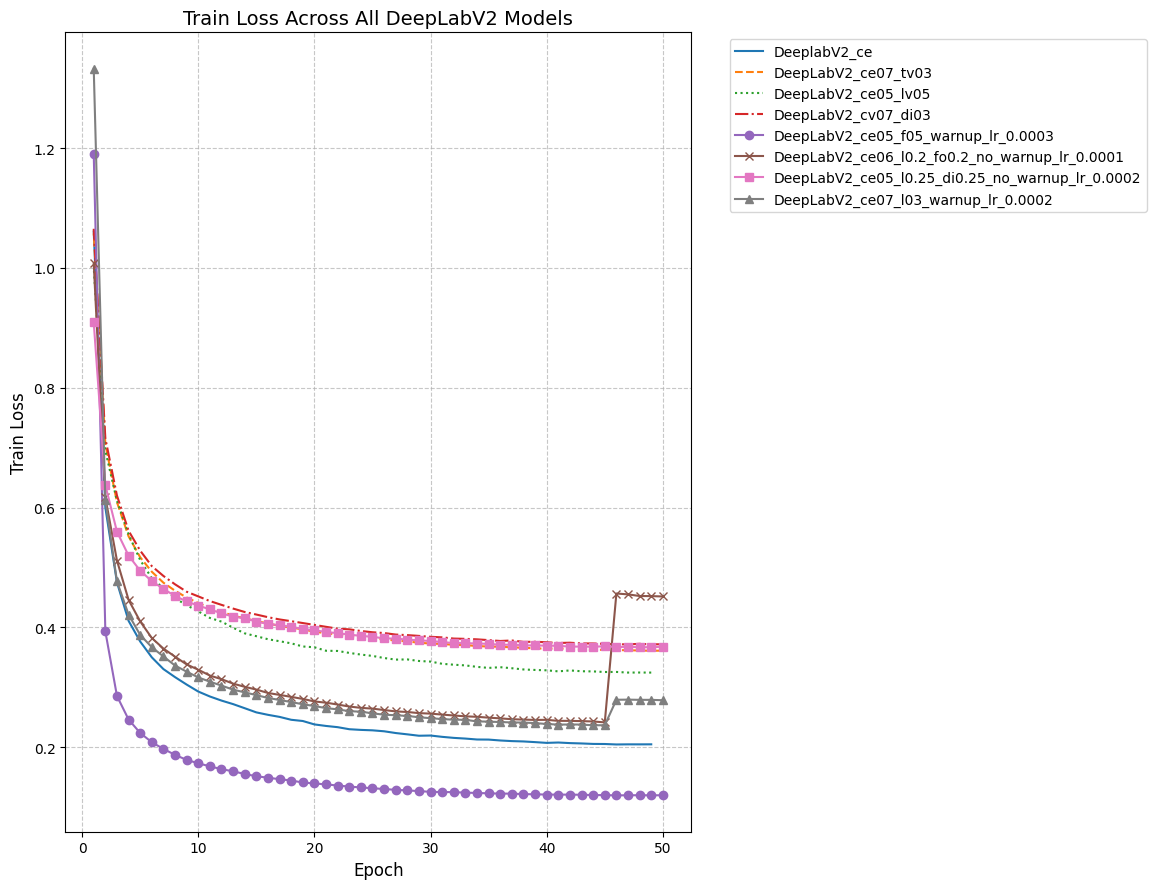

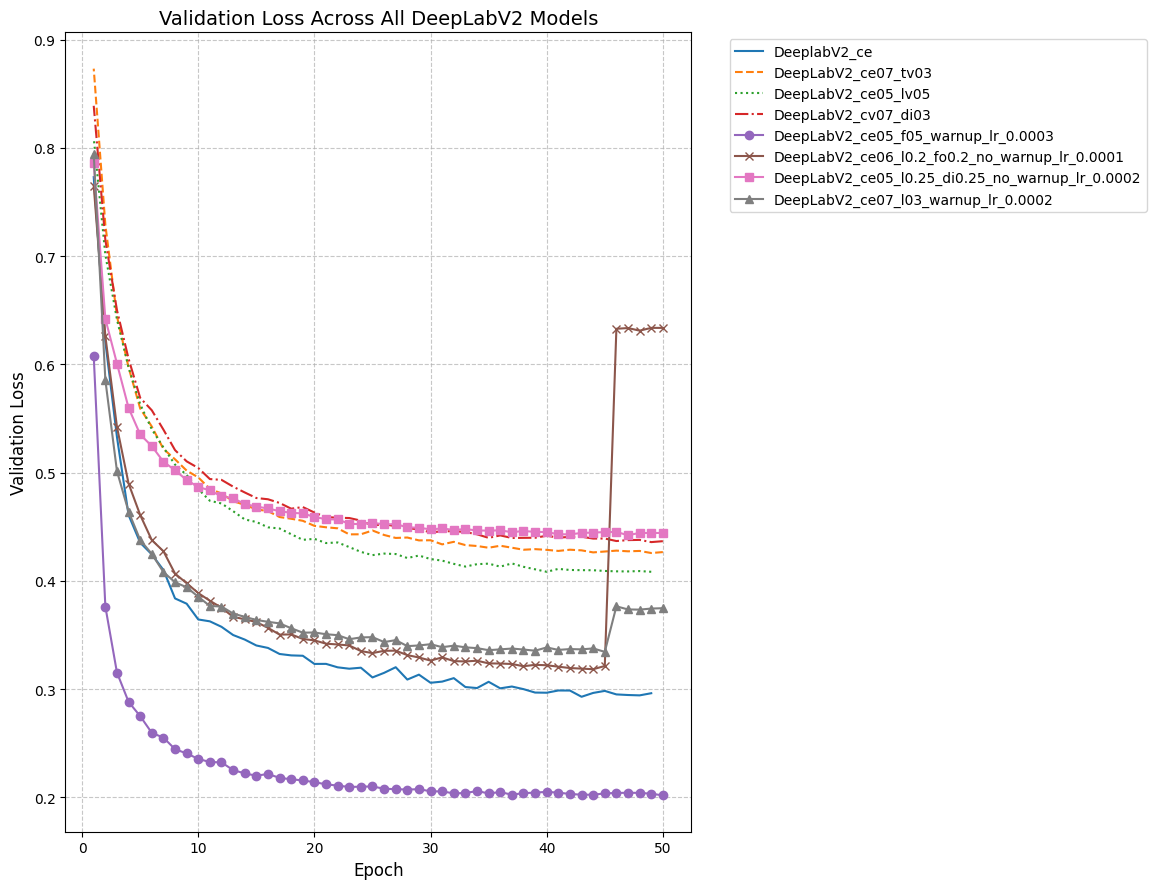

In [9]:
# Define a list of different line styles and markers to cycle through
line_styles = ['-', '--', ':', '-.',  # Standard line styles
               'o-', 'x-', 's-', '^-'] # Line styles with markers (circle, x, square, triangle_up)

# --- Plot for all Train Losses ---
plt.figure(figsize=(14, 9))
plt.title("Train Loss Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Train Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)]
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'train_loss' in df.columns:
            epochs = df['epoch']
            train_loss = df['train_loss']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, train_loss, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping train loss for '{file_name}': Missing 'epoch' or 'train_loss' column.")
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for train loss plot. Please ensure it's in the correct directory.")
    except Exception as e:
        print(f"An error occurred while processing train loss for '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

# --- Plot for all Validation Losses ---
plt.figure(figsize=(14, 9))
plt.title("Validation Loss Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)] # Use the same cycle of styles
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'val_loss' in df.columns:
            epochs = df['epoch']
            val_loss = df['val_loss']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, val_loss, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping validation loss for '{file_name}': Missing 'epoch' or 'val_loss' column.")
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for validation loss plot. Please ensure it's in the correct directory.")
    except Exception as e:
        print(f"An error occurred while processing validation loss for '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

## Mean train and validation mIoU
### **mIoU vs Epoch**

* **What it shows**: The mean Intersection over Union (mIoU) on validation over time.
* **Interpretation**: Lovász gets the best final mIoU, while Cross Entropy (CE) converges quickly but on lower values. Combinations (e.g. CE+Lovász) improve stability and performance.

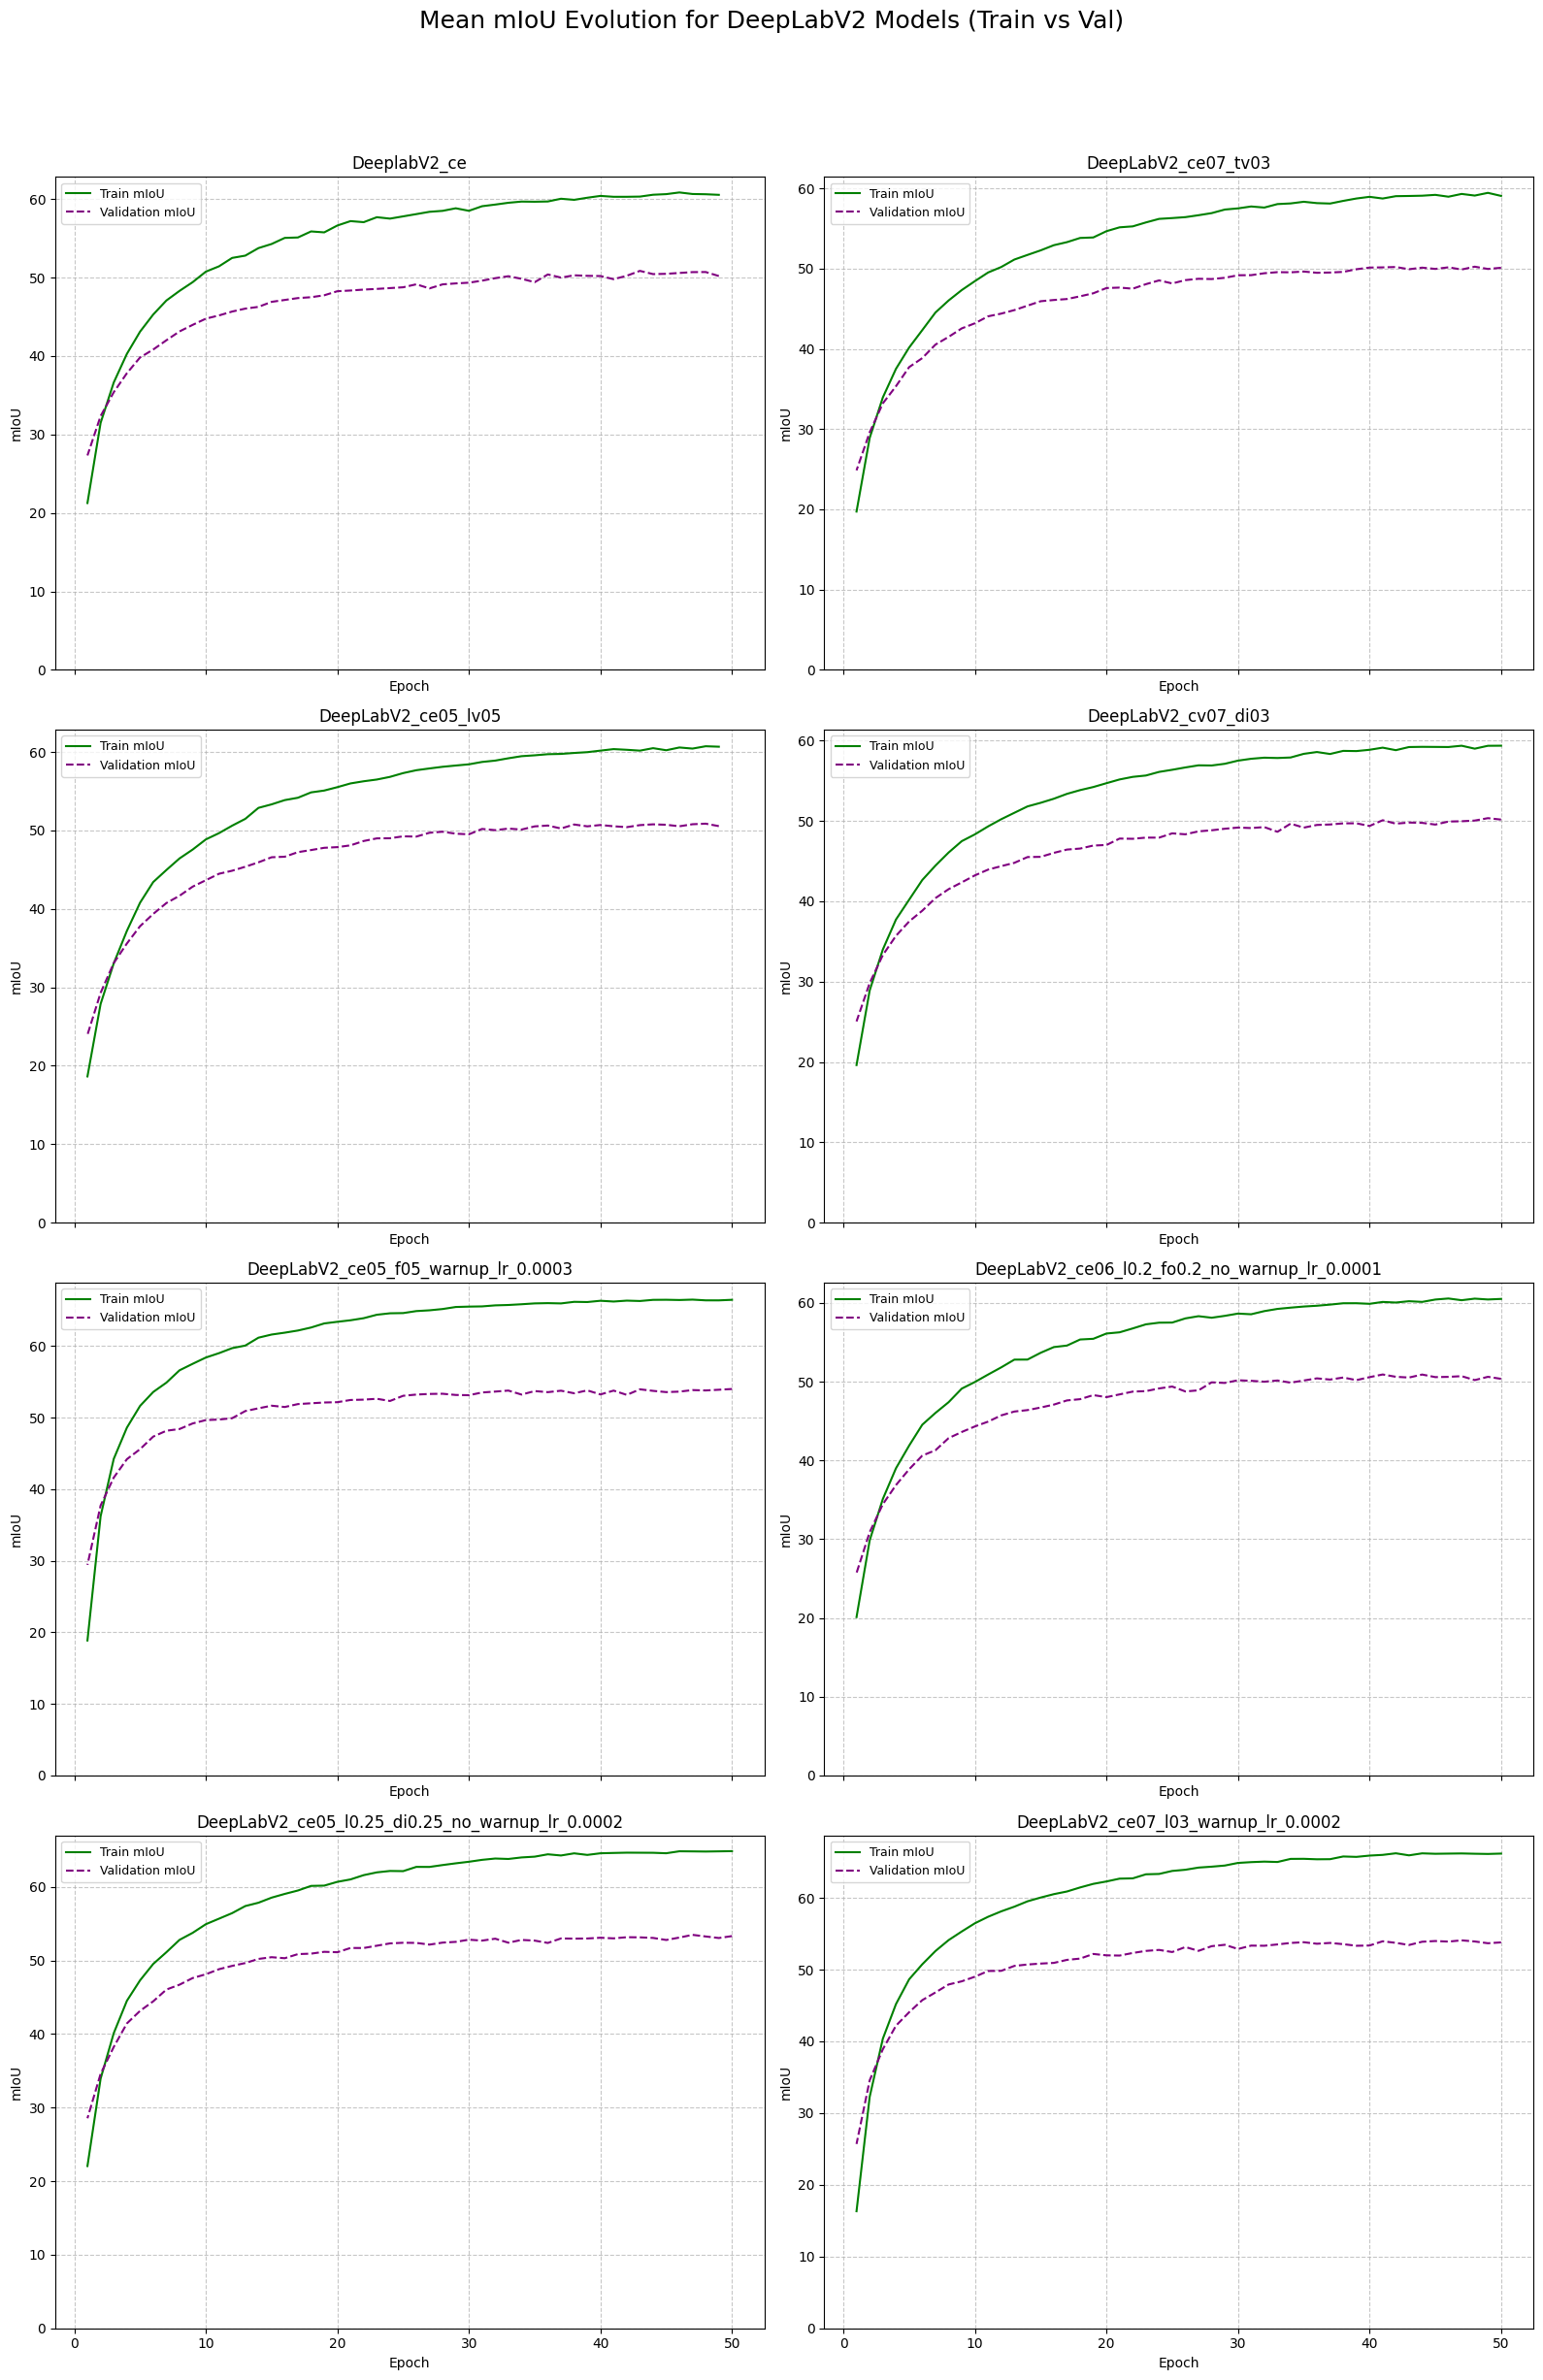


--- Final mIoU Table ---
                                          Model Final Train mIoU Final Val mIoU Val mIoU (Class_0) Val mIoU (Class_1) Val mIoU (Class_2) Val mIoU (Class_3) Val mIoU (Class_4) Val mIoU (Class_5) Val mIoU (Class_6) Val mIoU (Class_7) Val mIoU (Class_8) Val mIoU (Class_9) Val mIoU (Class_10) Val mIoU (Class_11) Val mIoU (Class_12) Val mIoU (Class_13) Val mIoU (Class_14) Val mIoU (Class_15) Val mIoU (Class_16) Val mIoU (Class_17) Val mIoU (Class_18)
                                   DeeplabV2_ce              nan            nan                nan                nan                nan                nan                nan                nan                nan                nan                nan                nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan
                            DeepLabV2_ce07_tv03          19.7200        24

In [ ]:
# Define number of classes based on the header provided earlier (class_0 to class_18)
NUM_CLASSES = 19 
class_val_cols = [f'class_{c}_val' for c in range(NUM_CLASSES)]
class_train_cols = [f'class_{c}_train' for c in range(NUM_CLASSES)]


# --- Part 1: Plots of mIoU evolution ---
fig, axes = plt.subplots(4, 2, figsize=(16, 24), sharex=True, sharey=False)
axes = axes.flatten()

fig.suptitle("Mean mIoU Evolution for DeepLabV2 Models (Train vs Val)", fontsize=18, y=1.02)

for i, file_name in enumerate(file_names):
    ax = axes[i]
    
    try:
        df = pd.read_csv(file_name)

        required_cols = ['epoch', 'train_mIoU', 'val_mIoU']
        if all(col in df.columns for col in required_cols):
            epochs = df['epoch']
            train_mIoU = df['train_mIoU']
            val_mIoU = df['val_mIoU']
            
            model_name = os.path.splitext(file_name)[0]
            
            ax.plot(epochs, train_mIoU, label='Train mIoU', color='green', linewidth=1.5)
            ax.plot(epochs, val_mIoU, label='Validation mIoU', color='purple', linestyle='--', linewidth=1.5)
            
            ax.set_title(f"{model_name}", fontsize=12)
            ax.set_xlabel("Epoch", fontsize=10)
            ax.set_ylabel("mIoU", fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_ylim(bottom=0) # Ensure mIoU starts from 0 or close to it
        else:
            missing_cols = [col for col in required_cols if col not in df.columns]
            ax.set_title(f"Skipping {file_name}: Missing columns {missing_cols}", fontsize=10)
            ax.text(0.5, 0.5, "Data N/A", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            print(f"Skipping mIoU plot for '{file_name}': Missing columns: {missing_cols}")
            
    except FileNotFoundError:
        ax.set_title(f"File Not Found: {file_name}", fontsize=10)
        ax.text(0.5, 0.5, "File Missing", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"Error: File '{file_name}' not found for mIoU plot.")
    except Exception as e:
        ax.set_title(f"Error for {file_name}", fontsize=10)
        ax.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"An error occurred while processing mIoU plot for '{file_name}': {e}")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# --- Part 2: Final mIoU Table ---
final_miou_data = []

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]
    try:
        df = pd.read_csv(file_name)
        # Get the last row (assuming last epoch is the last row)
        last_row = df.iloc[-1]

        # Extract mean mIoU
        final_train_mIoU = last_row.get('train_mIoU_final', last_row.get('train_mIoU', 'N/A')) # Check for _final or regular
        final_val_mIoU = last_row.get('val_mIoU_final', last_row.get('val_mIoU', 'N/A')) # Check for _final or regular

        # Extract per-class mIoU for validation
        per_class_val_miou = {}
        missing_per_class_cols = False
        for c_col in class_val_cols:
            if c_col in last_row:
                per_class_val_miou[f'Class_{c_col.split("_")[1]}'] = last_row[c_col]
            else:
                missing_per_class_cols = True
                break # Stop if a class column is missing

        row_data = {
            'Model': model_name,
            'Final Train mIoU': f'{final_train_mIoU:.4f}' if isinstance(final_train_mIoU, (int, float)) else final_train_mIoU,
            'Final Val mIoU': f'{final_val_mIoU:.4f}' if isinstance(final_val_mIoU, (int, float)) else final_val_mIoU,
        }
        
        if not missing_per_class_cols:
            # Add per-class mIoUs to the row data, formatted for display
            for class_name, val in per_class_val_miou.items():
                row_data[f'Val mIoU ({class_name})'] = f'{val:.4f}' if isinstance(val, (int, float)) else val
        else:
            print(f"Warning: Per-class validation mIoU columns not found for '{file_name}'. Table will not include them for this model.")
            # Add placeholders or omit columns if missing
            for c_col in class_val_cols:
                 row_data[f'Val mIoU (Class_{c_col.split("_")[1]})'] = 'N/A'


        final_miou_data.append(row_data)

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for mIoU table. Skipping.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}' for mIoU table: {e}")

if final_miou_data:
    df_final_miou = pd.DataFrame(final_miou_data)
    # Display the table
    print("\n--- Final mIoU Table ---")
    print(df_final_miou.to_string(index=False))
else:
    print("\nNo data processed for the final mIoU table.")

## Mean train and validation mIoU allover the DeepLabV2 models
### **mIoU per Class**

* **What it shows**: Performance of each method on each class (e.g. car, road, pedestrian, etc.).
* **Interpretation**: Focal losses (Focal, Tversky) improve in less represented classes, while EC strongly penalises these. Lovász performs well overall in all classes.

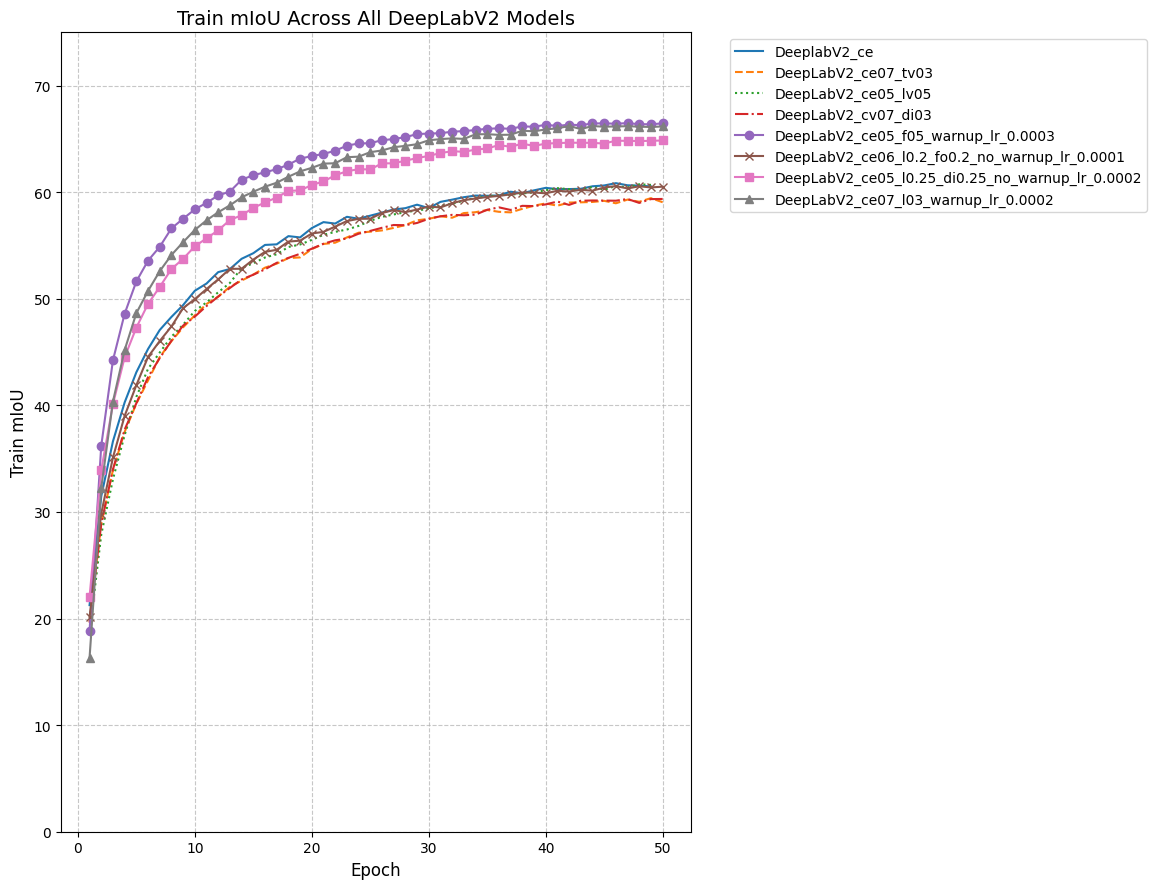

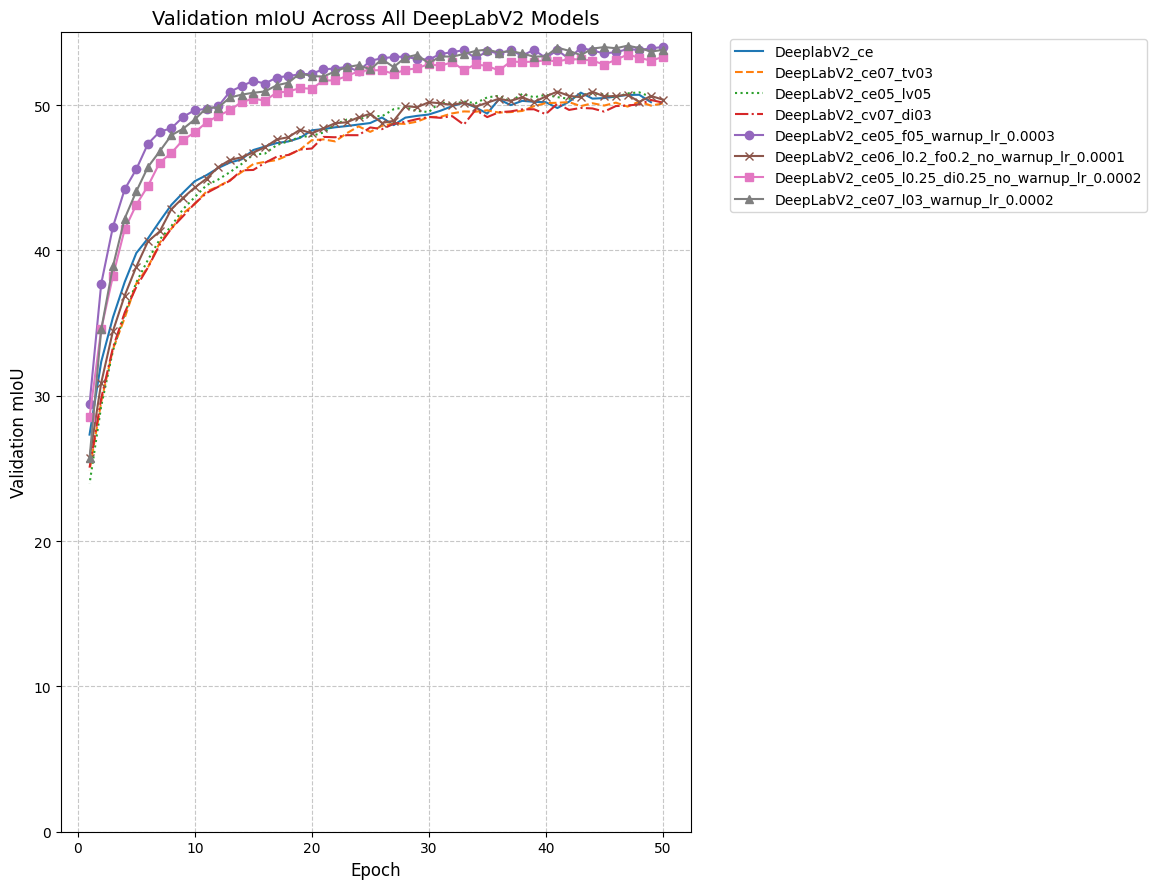

In [11]:
# Define a list of different line styles and markers to cycle through
# Matplotlib automatically cycles colors, so we'll focus on line styles and markers.
line_styles = ['-', '--', ':', '-.',  # Standard line styles
               'o-', 'x-', 's-', '^-'] # Line styles with markers (circle, x, square, triangle_up)


# --- Plot for all Train mIoU Curves ---
plt.figure(figsize=(14, 9))
plt.title("Train mIoU Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Train mIoU", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 75) # <--- MODIFICA QUI: impostato l'asse Y da 0 a 55


for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)]
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'train_mIoU' in df.columns:
            epochs = df['epoch']
            train_mIoU = df['train_mIoU']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, train_mIoU, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping train mIoU for '{file_name}': Missing 'epoch' or 'train_mIoU' column.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato per il plot della train mIoU. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione della train mIoU per '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()


# --- Plot for all Validation mIoU Curves ---
plt.figure(figsize=(14, 9))
plt.title("Validation mIoU Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation mIoU", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 55) # <--- MODIFICA QUI: impostato l'asse Y da 0 a 55


for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)] # Use the same cycle of styles
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'val_mIoU' in df.columns:
            epochs = df['epoch']
            val_mIoU = df['val_mIoU']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, val_mIoU, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping validation mIoU for '{file_name}': Missing 'epoch' or 'val_mIoU' column.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato per il plot della validation mIoU. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione della validation mIoU per '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

## Execution time comparison

Processing execution times and mIoU for analysis...


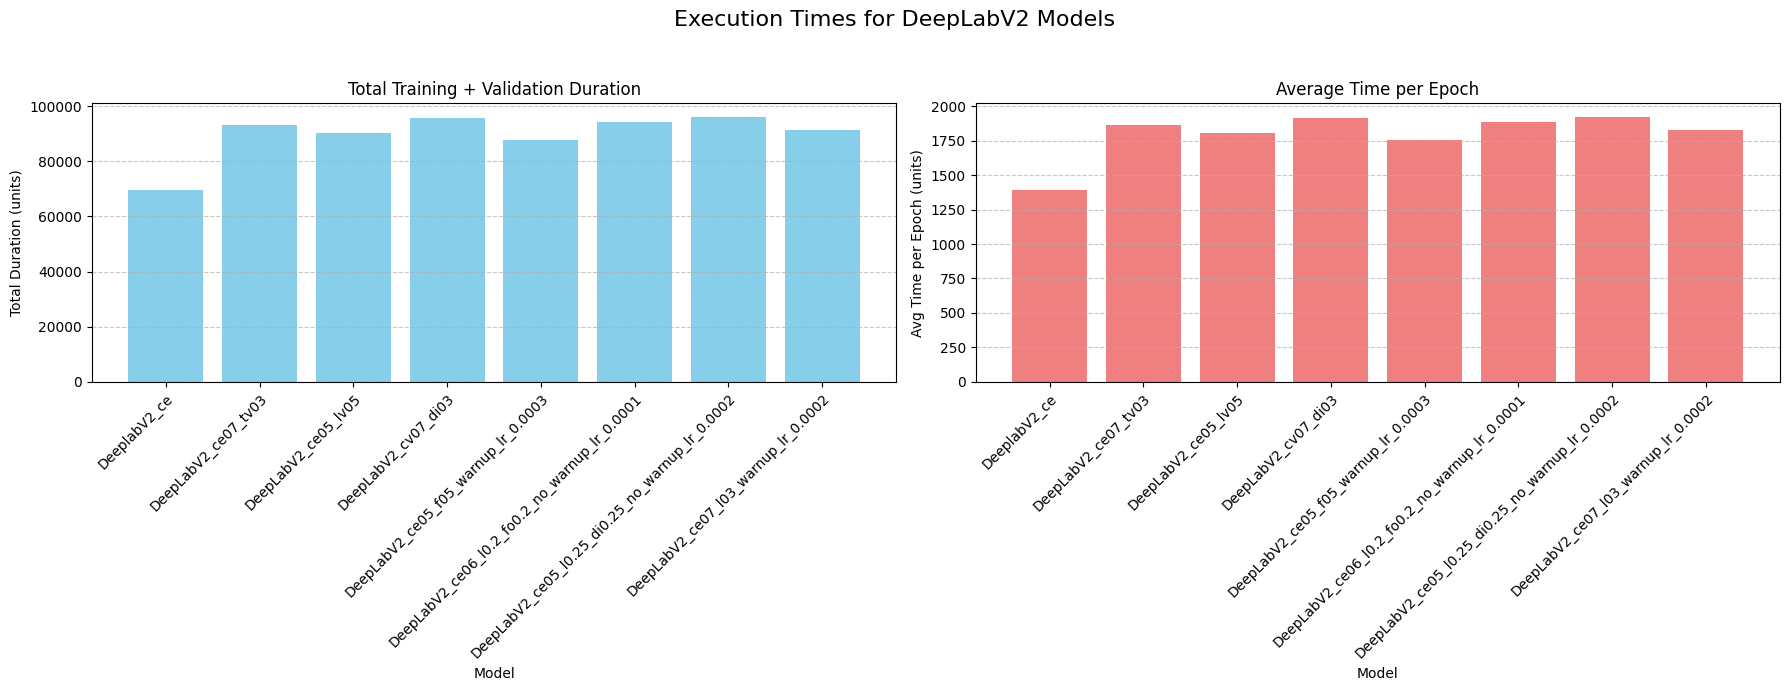

In [12]:
# Data structures to store results
time_metrics = []
trade_off_data = []

print("Processing execution times and mIoU for analysis...")

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]
    
    try:
        df = pd.read_csv(file_name)

        # Check for required columns for time calculation (now just 'Runtime')
        required_time_col = 'Runtime'
        
        # Calculate total and average time
        if required_time_col in df.columns:
            # Sum all values in the 'Runtime' column to get the total duration
            total_duration_sum = df[required_time_col].sum()
            num_epochs = df['epoch'].max() if not df.empty else 0
            
            # Calculate average time per epoch
            avg_time_per_epoch = total_duration_sum / num_epochs if num_epochs > 0 else 0

            time_metrics.append({
                'Model': model_name,
                'Total Duration': total_duration_sum,
                'Avg Time per Epoch': avg_time_per_epoch
            })
            
            # Extract final validation mIoU for trade-off analysis
            # Prioritize 'val_mIoU_final', fallback to 'val_mIoU' of the last epoch
            final_val_mIoU = None
            if 'val_mIoU_final' in df.columns:
                final_val_mIoU = df['val_mIoU_final'].iloc[-1]
            elif 'val_mIoU' in df.columns: 
                final_val_mIoU = df['val_mIoU'].iloc[-1]
            else:
                print(f"Warning: Neither 'val_mIoU_final' nor 'val_mIoU' found for '{file_name}'. Cannot assess accuracy for trade-off.")

            if final_val_mIoU is not None:
                trade_off_data.append({
                    'Model': model_name,
                    'Total Duration': total_duration_sum,
                    'Final Val mIoU': final_val_mIoU
                })
        else:
            print(f"Skipping time metrics for '{file_name}': Missing '{required_time_col}' column.")
            
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Skipping.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}': {e}. Skipping.")

# Convert to DataFrame for easier plotting and display
df_time_metrics = pd.DataFrame(time_metrics)
df_trade_off = pd.DataFrame(trade_off_data)

# --- Part 1: Plotting Total and Average Times ---
if not df_time_metrics.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle("Execution Times for DeepLabV2 Models", fontsize=16)

    # Total Duration Plot
    axes[0].bar(df_time_metrics['Model'], df_time_metrics['Total Duration'], color='skyblue')
    axes[0].set_title("Total Training + Validation Duration", fontsize=12)
    axes[0].set_xlabel("Model", fontsize=10)
    axes[0].set_ylabel("Total Duration (units)", fontsize=10) # Unit depends on your CSV (e.g., seconds, minutes)
    axes[0].tick_params(axis='x', rotation=0) # Rimosso ha='right' da tick_params
    # Imposta la rotazione e l'allineamento delle etichette separatamente
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Average Time per Epoch Plot
    axes[1].bar(df_time_metrics['Model'], df_time_metrics['Avg Time per Epoch'], color='lightcoral')
    axes[1].set_title("Average Time per Epoch", fontsize=12)
    axes[1].set_xlabel("Model", fontsize=10)
    axes[1].set_ylabel("Avg Time per Epoch (units)", fontsize=10)
    axes[1].tick_params(axis='x', rotation=0) # Rimosso ha='right' da tick_params
    # Imposta la rotazione e l'allineamento delle etichette separatamente
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent main title overlap
    plt.show()
else:
    print("No time metrics data available for plotting.")



## Conclusions

In this work, we explored the performance of DeepLabV2, a classic semantic segmentation architecture, on the Cityscapes dataset using various loss functions. Our key findings are:

- **Cross-Entropy Loss**, while simple and commonly used, showed limited ability to handle class imbalance.
- **Lovász-Softmax Loss** achieved the best performance in terms of mean IoU, aligning well with the evaluation metric and optimizing for segmentation quality.
- **Tversky and Focal Losses** provided a trade-off between class imbalance handling and boundary precision, especially useful in under-represented classes.
- Training stability and convergence behavior differed across losses, highlighting the importance of choosing a loss function aligned with the task-specific challenges.

From a computational standpoint, DeepLabV2 remains competitive in terms of parameter efficiency, but more modern architectures may provide improved trade-offs between accuracy and speed.

Future work may focus on integrating data augmentation, evaluating newer backbones, or incorporating hybrid losses to further boost performance. Overall, this study provides a comprehensive comparison framework for loss selection in semantic segmentation tasks.